<a href="https://colab.research.google.com/github/jiachengma/NNProperty/blob/main/PINN_property_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install CoolProp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.nn import MSELoss
import matplotlib.pyplot as plt
import numpy as np
from CoolProp.CoolProp import PropsSI
import CoolProp
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pickle import dump

In [ ]:
class PINNmodel(object):
    """
    Physics-informed neural networks for density, temperature, specific heat, and density partial derivatives w.r.t. (p, h)
    """
    def __init__(self, medium, p_max, p_min, h_max, h_min, net, criterion, normalizer):
        self.medium = medium
        self.p_max = p_max
        self.p_min = p_min
        self.h_max = h_max
        self.h_min = h_min
        self.net = net
        self.criterion = criterion
        self.normalizer = normalizer


    def generateSatData(self, n=100, phase='bubble'):
        if phase not in ['bubble', 'dew']:
          raise Exception("phase input should be 'bubble' or 'dew'")
        p = self.p_min + (self.p_max - self.p_min) * np.random.rand(n)
        q = 0 if phase=='bubble' else 1
        d = PropsSI('Dmass', 'P', p, 'Q', q, self.medium)
        h = PropsSI('Hmass', 'P', p, 'Q', q, self.medium)
        T = PropsSI('T', 'P', p, 'Q', q, self.medium)
        cp = PropsSI('C', 'P', p, 'Q', q, self.medium)
        dddp = PropsSI('d(Dmass)/d(P)|sigma', 'P', p, 'Q', q, self.medium)
        dhdp = PropsSI('d(Hmass)/d(P)|sigma', 'P', p, 'Q', q, self.medium)
        dTdp = PropsSI('d(T)/d(P)|sigma', 'P', p, 'Q', q, self.medium)
        # return np.stack((p, d, h, T, 1/cp, dddp, dhdp), axis=1)
        return (p, d, h, T, cp, dddp, dhdp)
        # np.savez(self.save_data_path+'bubble.npz', p=p_input, d=d_f, h=h_f, dddp=dddp_f, dhdp=dhdp_f)
        # np.savez(self.save_data_path+'dew.npz', p=p_input, d=d_g, h=h_g, dddp=dddp_g, dhdp=dhdp_g)

    def generateSinglePhaseData(self, n_p, n_h, phase='liquid'):
        """
        Generate single-phase training data
        n_p     -- number of pressure samples
        n_h     -- number of enthalpy samples per pressure
        phase   -- liquid or vapor
        """
        p_range = self.p_min + (self.p_max - self.p_min) * np.random.rand(n_p)
        p_data = np.kron(p_range.reshape(-1,1), np.ones((1, n_h)))
        if phase == 'liquid':
          h_f = PropsSI('Hmass', 'P', p_range, 'Q', 0, self.medium)
          h_data_l = np.tile(h_f-self.h_min, (n_h,1)).T * np.random.rand(n_p, n_h) + self.h_min
          input_sp = np.hstack((p_data.flatten()[:,None], h_data_l.flatten()[:,None]))
          d_l = PropsSI('Dmass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          cp_l = PropsSI('C', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          T_l = PropsSI('T', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          dTdp_l = PropsSI('d(T)/d(P)|Hmass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          dddp_l = PropsSI('d(Dmass)/d(P)|Hmass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          dddh_l = PropsSI('d(Dmass)/d(Hmass)|P', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          return np.hstack((input_sp, d_l[:,None], T_l[:,None], dTdp_l[:,None], 1/cp_l[:,None], dddp_l[:,None], dddh_l[:,None]))
        else:
          h_g = PropsSI('Hmass', 'P', p_range, 'Q', 1, self.medium)
          h_data_v = np.tile(self.h_max - h_g, (n_h,1)).T * np.random.rand(n_p, n_h) + np.tile(h_g, (n_h,1)).T
          input_sp = np.hstack((p_data.flatten()[:,None], h_data_v.flatten()[:,None]))
          d_v = PropsSI('Dmass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          cp_v = PropsSI('C', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          T_v = PropsSI('T', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          s_v = PropsSI('Smass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          dTdp_v = PropsSI('d(T)/d(P)|Hmass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          dddp_v = PropsSI('d(Dmass)/d(P)|Hmass', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          dddh_v = PropsSI('d(Dmass)/d(Hmass)|P', 'P', input_sp[:,0], 'Hmass', input_sp[:,1], self.medium)
          return np.hstack((input_sp, d_v[:,None], T_v[:,None], dTdp_v[:,None], 1/cp_v[:,None], dddp_v[:,None], dddh_v[:,None]))
        # np.savez('liquid.npz', p=input_sp[:,0], h=input_sp[:,1], d=d_l, T=T_l, cp=cp_l, dddp=dddp_l, dddh=dddh_l)
        # np.savez('vapor.npz', p=input_sp[:,0], h=input_sp[:,2], d=d_v, T=T_v, cp=cp_v, dddp=dddp_v, dddh=dddh_v)

    def loss_sp(self, input, output, deriv, alpha):
      """single phase loss function"""
      input.requires_grad = True
      y = self.net(input)
      drho = torch.autograd.grad(y[:,0], input, grad_outputs=torch.ones_like(y[:,0]),
                                  create_graph=True)[0]
      dTdh = torch.autograd.grad(y[:,1], input, grad_outputs=torch.ones_like(y[:,1]),
                                  create_graph=True)[0][:,1:2]
      deriv_pred = torch.hstack((dTdh, drho))
      return self.criterion(y, output) + alpha * self.criterion(deriv, deriv_pred)
      # return self.criterion(y, output) + alpha * self.criterion(dTdh, deriv[:,0:1]) + alpha * self.criterion(drho[:,0:1], deriv[:,1:2]) + alpha * self.criterion(drho[:,1:2], deriv[:,2:3])

    def loss_sat(self, input, output, deriv, alpha):
      input.requires_grad = True
      y = self.net(input)

    def train_pinn(self, epochs, loss_f, train_input, train_output, train_deriv, alpha):
      """train single phase media model"""
      optimizer = torch.optim.LBFGS(self.net.parameters())
      def closure():
        optimizer.zero_grad()
        l = loss_f(train_input, train_output, train_deriv, alpha)
        l.backward()
        return l
      self.net.train()
      for iter in range(epochs):
        optimizer.step(closure)
        # run again to print loss
        ls_iter = closure()
        print(f'Epoch {iter+1}, Loss: {ls_iter.item()}')


    def normalize(self, data):
      data_prop = data[:,:4]
      data_deriv = data[:,4:]
      norm_prop = self.normalizer.fit_transform(data_prop) # normalized property data for (p, h, d, T)
      scale = self.normalizer.scale_
      norm_deriv = np.stack((scale[-1]/scale[0]*data_deriv[:,0], scale[-1]/scale[1]*data_deriv[:,1], scale[2]/scale[0]*data_deriv[:,2], scale[2]/scale[1]*data_deriv[:,-1]), axis=1) # normalized property data for (1/cp, dddp, dddh)
      return np.hstack((norm_prop, norm_deriv))

    def train_singlePhase(self, n_p=10, n_h=10, phase='liquid', epochs=10, alpha=0.1):
      if phase not in ['liquid', 'vapor']:
          raise Exception("phase input should be liquid or vapor")
      # generate data
      data = self.generateSinglePhaseData(n_p, n_h, phase)
      data_norm = self.normalize(data)
      train_input = torch.from_numpy(data_norm[:,:2]).float()
      train_output = torch.from_numpy(data_norm[:,2:4]).float()
      train_deriv = torch.from_numpy(data_norm[:,5:]).float()
      # training
      self.train_pinn(epochs, self.loss_sp, train_input, train_output, train_deriv, alpha)

    def plot_validate(self, data_true, data_pred):
      n = data_true.shape[1]
      fig, ax = plt.subplots(n, 1, figsize=(15, 20))
      for i in range(n):
        ax[i].plot(data_true[:,i], data_pred[:,i], '.')
        y_min = data_true[:,i].min()
        y_max = data_true[:,i].max()
        ax[i].plot(np.linspace(y_min, y_max), np.linspace(y_min, y_max))

    def validate_singlePhase(self, n_p=10, n_h=10, phase='liquid', criterion=None, plot=1):
      data = self.generateSinglePhaseData(n_p, n_h, phase)
      norm_prop = self.normalizer.transform(data[:,:4])
      input_norm = torch.from_numpy(norm_prop[:,:2]).float()
      output_true = data[:,2:4] # density and temperature
      cp_true = 1 / data[:,5:6]
      dd_true = data[:,6:]
      input_norm.requires_grad = True
      self.net.eval()
      output_norm = self.net(input_norm)
      scale = self.normalizer.scale_
      cp_pred = 1 / (torch.autograd.grad(output_norm[:,1], input_norm, grad_outputs=torch.ones_like(output_norm[:,1]), create_graph=True)[0][:,1:2] * scale[1] / scale[-1])
      dd_pred_norm = torch.autograd.grad(output_norm[:,0], input_norm, grad_outputs=torch.ones_like(output_norm[:,0]), create_graph=True)[0]
      dddp_pred = dd_pred_norm[:,0:1] * scale[0] / scale[2]
      dddh_pred = dd_pred_norm[:,1:2] * scale[1] / scale[2]
      output_pred = self.normalizer.inverse_transform(np.hstack((input_norm.detach().numpy(), output_norm.detach().numpy())))[:,2:]
      error_output = criterion(output_pred, output_true, multioutput='raw_values')
      deriv_true = np.hstack((cp_true, dd_true))
      deriv_pred = np.hstack((cp_pred.detach().numpy(), dddp_pred.detach().numpy(), dddh_pred.detach().numpy()))
      error_deriv = criterion(deriv_true, deriv_pred, multioutput='raw_values')
      print(f'MAPE for d and T: {error_output}, MAPE for cp, dddp, dddh: {error_deriv}')
      # print(f'MAPE for d and T: {error_output}')
      if plot:
        self.plot_validate(np.hstack((output_true, deriv_true)), np.hstack((output_pred, deriv_pred)))
      return (error_output, error_deriv)

    def save_model(self, model_name):
      torch.save(self.net, model_name+'.pth') # save torch model
      dump(self.normalizer, open('normalizer.pkl', 'wb')) # save normalize




Epoch 1, Loss: 0.11327589303255081
Epoch 2, Loss: 0.011365637183189392
Epoch 3, Loss: 0.0013418050948530436
Epoch 4, Loss: 0.0005343296797946095
Epoch 5, Loss: 0.0003431156219448894
Epoch 6, Loss: 0.00019584957044571638
Epoch 7, Loss: 0.00012670400610659271
Epoch 8, Loss: 8.220982272177935e-05
Epoch 9, Loss: 6.489028601208702e-05
Epoch 10, Loss: 5.101448914501816e-05
Epoch 11, Loss: 4.5777411287417635e-05
Epoch 12, Loss: 3.6082092265132815e-05
Epoch 13, Loss: 3.071950050070882e-05
Epoch 14, Loss: 2.8397314963513054e-05
Epoch 15, Loss: 2.4708153432584368e-05
Epoch 16, Loss: 1.9504563169903122e-05
Epoch 17, Loss: 1.6603775293333456e-05
Epoch 18, Loss: 1.599363167770207e-05
Epoch 19, Loss: 1.3345748811843805e-05
Epoch 20, Loss: 1.1306121450616047e-05
Epoch 21, Loss: 9.501864042249508e-06
Epoch 22, Loss: 8.410012924287003e-06
Epoch 23, Loss: 7.190583801275352e-06
Epoch 24, Loss: 6.743298854416935e-06
Epoch 25, Loss: 6.4188488977379166e-06
Epoch 26, Loss: 5.849078206665581e-06
Epoch 27, Los

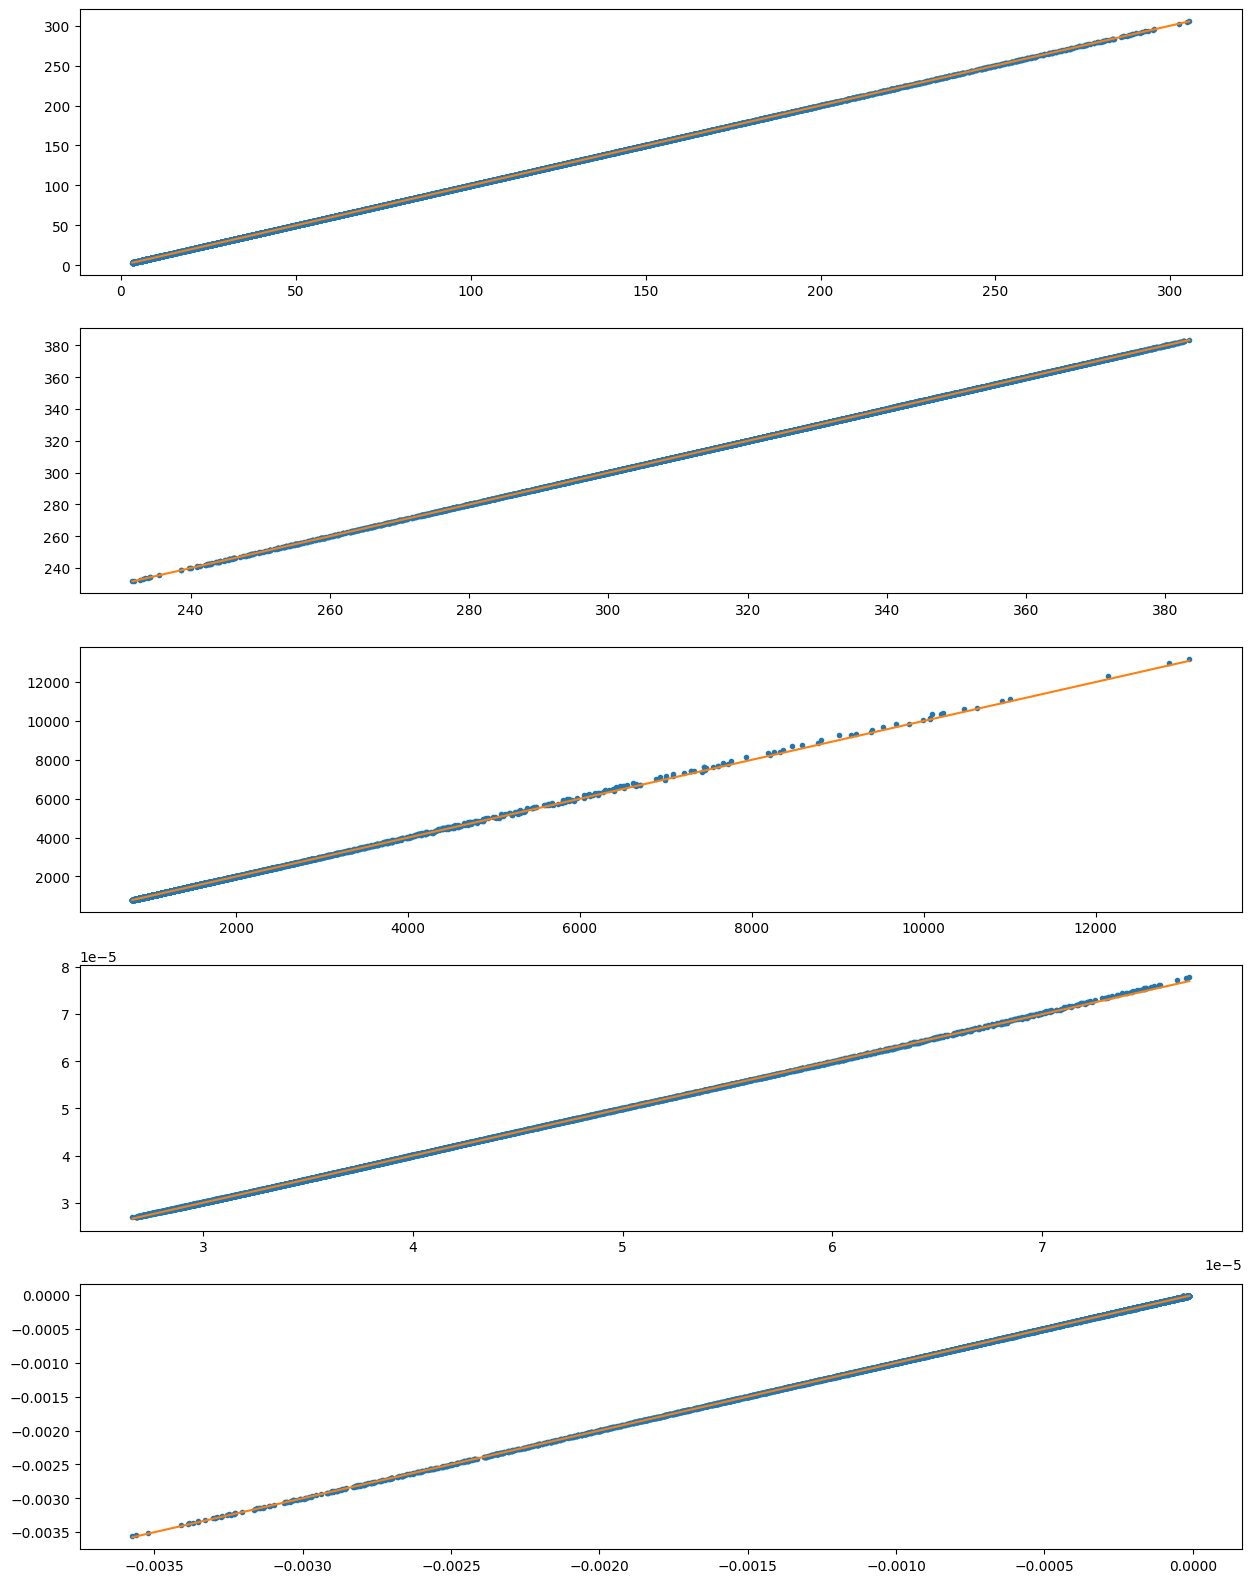

In [ ]:
medium = 'R410A'
p_crit = 4901200
p_min = 1e5
p_max = p_crit * 0.95
h_min = 1.1e5
h_max = 4.9e5
criterion = MSELoss()
normalizer = MinMaxScaler()
N = 7
phase = 'vapor'
net = nn.Sequential(nn.Linear(2,N),
                    nn.Sigmoid(),
                    nn.Linear(N,N),
                    nn.Sigmoid(),
                    nn.Linear(N,2))
model = PINNmodel(medium, p_max, p_min, h_max, h_min, net, criterion, normalizer)
model.train_singlePhase(150, 100, phase, 50, 5)
_ = model.validate_singlePhase(100, 100, phase, mean_absolute_percentage_error)

In [ ]:
# torch.save(model.net, 'R410a_vapor.pth')
model.save_model('R410a_vapor')

In [ ]:
for name, param in model.net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param}")

Layer: 0.weight | Size: torch.Size([7, 2]) | Values: Parameter containing:
tensor([[-2.0500,  0.5272],
        [ 1.1164,  0.5499],
        [-1.2776,  2.9509],
        [-5.8719, -1.9705],
        [-0.6404,  3.2461],
        [-0.8841,  1.1259],
        [-0.3009, -0.5861]], requires_grad=True)
Layer: 0.bias | Size: torch.Size([7]) | Values: Parameter containing:
tensor([ 1.4631, -0.1636,  2.3557, -2.7929,  1.4401, -0.9660,  0.1056],
       requires_grad=True)
Layer: 2.weight | Size: torch.Size([7, 7]) | Values: Parameter containing:
tensor([[-1.2744, -0.5951, -0.6664,  0.4304,  0.6329, -0.3390,  0.2283],
        [ 2.3083,  2.1922,  1.4425,  0.4412,  1.5068,  0.7914, -0.9733],
        [ 2.7468,  1.0436,  1.3652,  0.3379,  0.1966,  0.0085, -1.6976],
        [ 2.0232,  1.3013,  1.8669,  1.0080,  0.4683, -0.0962, -1.0647],
        [-0.9683,  2.0708, -3.7354, -1.8656,  1.6215,  0.9971,  1.2450],
        [-2.4430, -3.3921, -1.0117,  1.4343, -0.8232, -1.8341,  0.2497],
        [-1.0008,  1.0526,

In [ ]:
model.net.eval()

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=8, out_features=2, bias=True)
)

In [ ]:
scripted_model = torch.jit.script(model.net)

In [ ]:
scripted_model.save("scripted_model_liquid.pt")

In [ ]:
from pickle import dump
dump(model.normalizer, open('normalizer.pkl', 'wb'))